## 1. Part 2 - Classification, Clustering and PySpark

Import from scikit-learn, numpy and pandas

In [95]:
%pip install xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel
import xgboost as XGB

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Classification of lap time

In [96]:
file_path = "./Data.csv"
df = pd.read_csv(file_path)

In [97]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

shuffled_file_path = "./Data_shuffled.csv"
df.to_csv(shuffled_file_path, index=False)

print(f"Shuffled CSV file saved to {shuffled_file_path}")

Shuffled CSV file saved to ./Data_shuffled.csv


In [98]:
label_encoders = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [99]:
df.describe()

,average_speed,fuel_consumption,total_steering,total_throttle,total_brake,velocity,lap time,vehicle_name,lap,vehicle_type,...,rear_left_wheel_position_z,rear_right_wheel_radius,rear_right_wheel_max_brake_torque,rear_right_wheel_max_handbrake_torque,rear_right_wheel_lat_stiff_max_load,rear_right_wheel_lat_stiff_value,rear_right_wheel_long_stiff_value,rear_right_wheel_position_x,rear_right_wheel_position_y,rear_right_wheel_position_z
count,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.00000,8500.000000,...,8500.000000,8500.000000,8500.000000,8500.000000,8500.000000,8500.00000,8500.000000,8500.000000,8500.000000,8500.000000
mean,15.300034,0.007070,212.980726,47.940750,5.625210,4.561819,44.098026,8.000000,250.50000,1.117647,...,86.249518,37.411765,1294.117647,2588.235294,2.941176,18.00000,2235.294118,-829.983130,4428.750294,86.249529
std,0.570637,0.006269,50.565260,9.152733,4.022636,1.031912,1.818907,4.899268,144.34577,1.131560,...,5.988813,8.326981,694.108626,1388.217252,1.258953,1.78237,1058.885819,6294.228371,4994.571742,5.988818
min,13.603687,0.000248,120.460764,29.005589,0.534571,2.352162,38.703337,0.000000,1.00000,0.000000,...,73.714622,21.500000,400.000000,800.000000,1.000000,15.00000,1000.000000,-11518.075195,-5643.188477,73.714622
25%,14.931055,0.003310,171.702386,42.078381,2.772816,3.804269,42.696987,4.000000,125.75000,0.000000,...,84.157211,33.500000,800.000000,1600.000000,2.000000,17.00000,1000.000000,-5287.428711,1593.346680,84.157211
50%,15.441523,0.005387,192.574367,45.391252,3.915343,4.378021,43.953436,8.000000,250.50000,1.000000,...,86.128242,35.000000,1500.000000,3000.000000,3.000000,17.00000,3000.000000,-1688.020142,2868.444824,86.128242
75%,15.705991,0.007650,259.164424,53.116344,7.515535,5.171643,45.153419,12.000000,375.25000,2.000000,...,89.066559,37.500000,1500.000000,3000.000000,3.000000,20.00000,3000.000000,3398.295166,6962.188965,89.066559
max,16.862017,0.031828,302.456161,77.616349,20.134363,7.481782,49.688994,16.000000,500.00000,3.000000,...,98.503029,57.000000,3000.000000,6000.000000,5.000000,20.00000,4000.000000,10970.796875,13312.832031,98.503029


In [100]:
df = df.dropna()

### Categorizing Lap Time: Fast, Medium, Slow
Creating target variable to classify lap time. 

In [101]:
y_vehicle = df["vehicle_type"]


def categorize_lap_time(time):
    if time <= 42.5:
        return "Fast"
    elif 42.5 < time <= 45:
        return "Medium"
    else:
        return "Slow"


df["lap_time_category"] = df["lap time"].apply(categorize_lap_time)
y_lap = df["lap_time_category"]

We will drop the target column and set it as a label for the model. in this case `lap_time`

In [ ]:
X = df.drop(columns=["vehicle_type", "lap time", "lap_time_category"])
y = df["lap time"]

y_lap = LabelEncoder().fit_transform(y_lap)

In [103]:
X_train_lap, X_test_lap, y_train_lap, y_test_lap = train_test_split(
    X, y_lap, test_size=0.3, random_state=42
)

In [104]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_lap)
X_test = scaler.transform(X_test_lap)

## Classification Models and Hyperparameter Tuning

In [105]:
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=5),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(
        n_estimators=120,
        learning_rate=0.1,
        use_label_encoder=False,
        eval_metric="logloss",
    ),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=15),
}

## Model Training and Evaluation
evaluation using precision, recall, f1 score, and classification report


Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       499
           1       0.83      0.86      0.85      1271
           2       0.84      0.78      0.81       780

    accuracy                           0.83      2550
   macro avg       0.83      0.82      0.83      2550
weighted avg       0.83      0.83      0.83      2550


Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.85      0.77       499
           1       0.89      0.63      0.74      1271
           2       0.67      0.89      0.76       780

    accuracy                           0.75      2550
   macro avg       0.75      0.79      0.76      2550
weighted avg       0.79      0.75      0.75      2550



c:\Users\roeez\source\notebooks\pytourch\.venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:02:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82       499
           1       0.83      0.88      0.85      1271
           2       0.87      0.78      0.82       780

    accuracy                           0.84      2550
   macro avg       0.84      0.83      0.83      2550
weighted avg       0.84      0.84      0.84      2550


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       499
           1       0.84      0.88      0.86      1271
           2       0.88      0.78      0.82       780

    accuracy                           0.84      2550
   macro avg       0.84      0.84      0.84      2550
weighted avg       0.85      0.84      0.84      2550



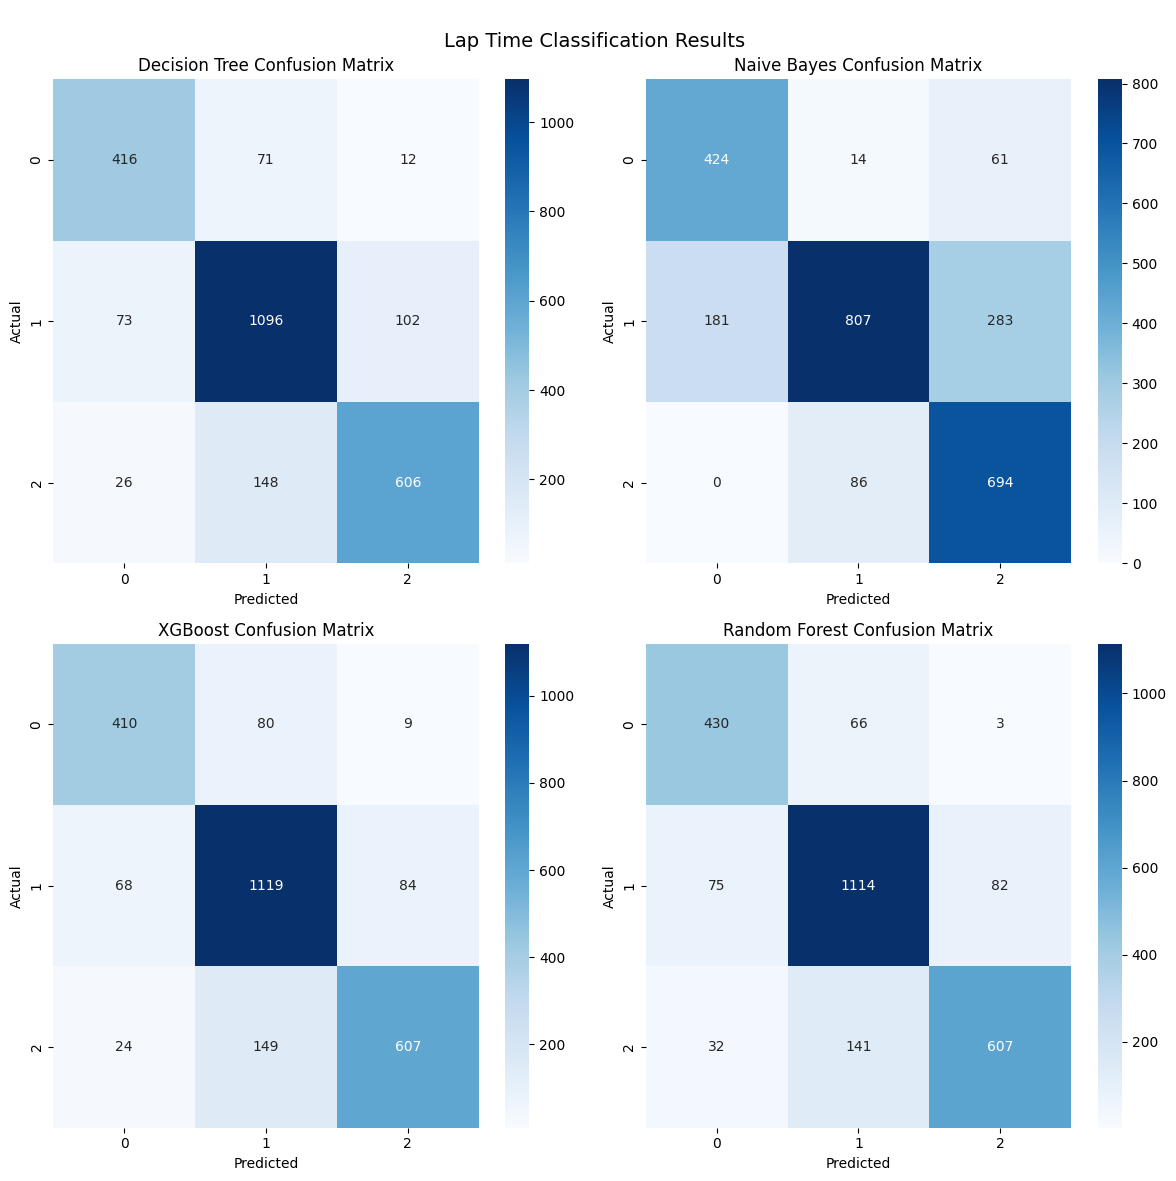

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.suptitle("\nLap Time Classification Results", fontsize=14)

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_lap, y_train_lap)
    y_pred = model.predict(X_test_lap)
    print(
        f"\n{name} Classification Report:\n", classification_report(y_test_lap, y_pred)
    )

    sns.heatmap(
        confusion_matrix(y_test_lap, y_pred),
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[i // 2, i % 2],
    )
    axes[i // 2, i % 2].set_title(f"{name} Confusion Matrix")
    axes[i // 2, i % 2].set_xlabel("Predicted")
    axes[i // 2, i % 2].set_ylabel("Actual")

plt.tight_layout()
plt.show()

## Vehicle Type Classification: Data Exploration

we found that there was a strong coorleation between one of the features (mass) and the feature we want to classify(vehicle type), therefore - we decided to drop some column and shuffle the data, making the preprocessing step more meaningfull.

In [ ]:
df = pd.read_csv("./Data.csv")

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save the shuffled DataFrame to a new CSV file
shuffled_file_path = "./Data_shuffled.csv"
df.to_csv(shuffled_file_path, index=False)

print(f"Shuffled CSV file saved to {shuffled_file_path}")
df

Shuffled CSV file saved to ./Data_shuffled.csv


,average_speed,fuel_consumption,total_steering,total_throttle,total_brake,velocity,lap time,vehicle_name,lap,vehicle_type,...,rear_left_wheel_position_z,rear_right_wheel_radius,rear_right_wheel_max_brake_torque,rear_right_wheel_max_handbrake_torque,rear_right_wheel_lat_stiff_max_load,rear_right_wheel_lat_stiff_value,rear_right_wheel_long_stiff_value,rear_right_wheel_position_x,rear_right_wheel_position_y,rear_right_wheel_position_z
0,16.761557,0.008330,144.970090,55.193212,8.874851,6.914119,44.901266,vehicle.tesla.cybertruck,245,Truck,...,98.503029,53.5,1600.0,3200.0,2.0,17.0,1000.0,-4433.316406,20.970810,98.503029
1,15.253209,0.002482,166.013005,43.163813,2.997979,2.455143,43.318199,vehicle.toyota.prius,314,Car,...,93.373116,37.0,800.0,1600.0,3.0,20.0,3000.0,-11518.075195,5544.257324,93.373116
2,15.713101,0.002494,271.003099,33.472689,2.691240,5.781884,47.059081,vehicle.vespa.zx125,20,Motorcycle,...,73.714622,21.5,1500.0,3000.0,2.0,17.0,1000.0,-137.477127,2441.143555,73.714622
3,15.302518,0.006131,165.632373,50.571982,3.165107,5.176160,42.442205,vehicle.nissan.patrol_2021,38,Car,...,89.348190,45.0,1500.0,3000.0,5.0,20.0,4000.0,-1688.020142,12930.127930,89.348366
4,15.343909,0.007834,142.860484,50.310407,7.980856,7.235589,46.354878,vehicle.tesla.cybertruck,308,Truck,...,98.503029,53.5,1600.0,3200.0,2.0,17.0,1000.0,-4433.316406,20.970810,98.503029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,14.380167,0.007294,175.731187,49.069397,5.159092,3.092050,42.525907,vehicle.nissan.patrol_2021,235,Car,...,89.348190,45.0,1500.0,3000.0,5.0,20.0,4000.0,-1688.020142,12930.127930,89.348366
8496,16.022074,0.005379,191.933611,44.132699,7.266676,3.789209,43.501336,vehicle.mini.cooper_s_2021,192,Car,...,88.880165,37.5,500.0,1000.0,1.0,17.0,3000.0,3398.295166,12957.139648,88.880165
8497,14.971989,0.005382,192.443201,45.178941,7.104845,4.981060,43.923082,vehicle.mini.cooper_s_2021,391,Car,...,88.880165,37.5,500.0,1000.0,1.0,17.0,3000.0,3398.295166,12957.139648,88.880165
8498,15.597976,0.012453,238.039968,49.891043,3.137115,4.156630,44.292306,vehicle.carlamotors.carlacola,361,Truck,...,89.066559,46.0,2700.0,5400.0,5.0,20.0,3000.0,1839.163330,2566.663330,89.066559


In [108]:
df = df.drop(
    columns=[
        "lap time",
        "mass",
        "center_of_mass_z",
        "front_left_wheel_long_stiff_value",
        "front_left_wheel_position_x",
        "front_left_wheel_position_y",
        "front_left_wheel_position_z",
        "front_right_wheel_long_stiff_value",
        "front_right_wheel_position_z",
        "rear_left_wheel_radius",
        "rear_left_wheel_max_handbrake_torque",
        "rear_left_wheel_long_stiff_value",
        "rear_left_wheel_position_y",
        "gear_switch_time",
        "front_left_wheel_radius",
        "front_left_wheel_max_brake_torque",
        "front_right_wheel_radius",
        "front_right_wheel_max_brake_torque",
        "front_right_wheel_position_x",
        "front_right_wheel_position_y",
        "rear_left_wheel_max_brake_torque",
        "rear_left_wheel_position_z",
        "rear_right_wheel_radius",
        "rear_right_wheel_max_brake_torque",
        "rear_right_wheel_max_handbrake_torque",
        "fuel_consumption",
        "total_steering",
        "total_throttle",
        "lap_time",
        "center_of_mass_x",
        "clutch_strength",
        "max_rpm",
        "front_left_wheel_max_steer_angle",
        "front_right_wheel_max_steer_angle",
        "front_right_wheel_lat_stiff_max_load",
        "rear_left_wheel_position_x",
        "rear_right_wheel_lat_stiff_max_load",
        "rear_right_wheel_long_stiff_value",
        "rear_right_wheel_position_x",
        "rear_right_wheel_position_y",
        "rear_right_wheel_position_z",
    ],
    errors="ignore",
)

In [109]:
df

,average_speed,total_brake,velocity,vehicle_name,lap,vehicle_type,drag_coefficient,front_left_wheel_lat_stiff_max_load,front_left_wheel_lat_stiff_value,front_right_wheel_lat_stiff_value,rear_left_wheel_lat_stiff_max_load,rear_left_wheel_lat_stiff_value,rear_right_wheel_lat_stiff_value
0,16.761557,8.874851,6.914119,vehicle.tesla.cybertruck,245,Truck,0.3,2.0,17.0,17.0,2.0,17.0,17.0
1,15.253209,2.997979,2.455143,vehicle.toyota.prius,314,Car,0.3,3.0,20.0,20.0,3.0,20.0,20.0
2,15.713101,2.691240,5.781884,vehicle.vespa.zx125,20,Motorcycle,0.3,2.0,17.0,17.0,2.0,17.0,17.0
3,15.302518,3.165107,5.176160,vehicle.nissan.patrol_2021,38,Car,0.3,5.0,20.0,20.0,5.0,20.0,20.0
4,15.343909,7.980856,7.235589,vehicle.tesla.cybertruck,308,Truck,0.3,2.0,17.0,17.0,2.0,17.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8495,14.380167,5.159092,3.092050,vehicle.nissan.patrol_2021,235,Car,0.3,5.0,20.0,20.0,5.0,20.0,20.0
8496,16.022074,7.266676,3.789209,vehicle.mini.cooper_s_2021,192,Car,0.3,1.0,17.0,17.0,1.0,17.0,17.0
8497,14.971989,7.104845,4.981060,vehicle.mini.cooper_s_2021,391,Car,0.3,1.0,17.0,17.0,1.0,17.0,17.0
8498,15.597976,3.137115,4.156630,vehicle.carlamotors.carlacola,361,Truck,0.3,5.0,20.0,20.0,5.0,20.0,20.0


In [ ]:
print(f"Dataset shape: {df.shape}")
print(f"Vehicle types and counts: \n{df['vehicle_type'].value_counts()}")
print(f"Missing values: \n{df.isnull().sum().sum()}")

df = df.dropna()

Dataset shape: (8500, 13)
Vehicle types and counts: 
vehicle_type
Car           3500
Motorcycle    2000
Truck         1500
Van           1500
Name: count, dtype: int64
Missing values: 
0


In [111]:
X = df.drop(columns=["vehicle_type", "vehicle_name", "lap"])
y = df["vehicle_type"]

if "lap time" in X.columns:
    X = X.rename(columns={"lap time": "lap_time"})

categorical_cols = X.select_dtypes(include=["object"]).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(
    f"Encoded class mapping: {dict(zip(le_target.classes_, range(len(le_target.classes_))))}"
)

Encoded class mapping: {'Car': 0, 'Motorcycle': 1, 'Truck': 2, 'Van': 3}


## Data Preprocessing: Splitting and Scaling Features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

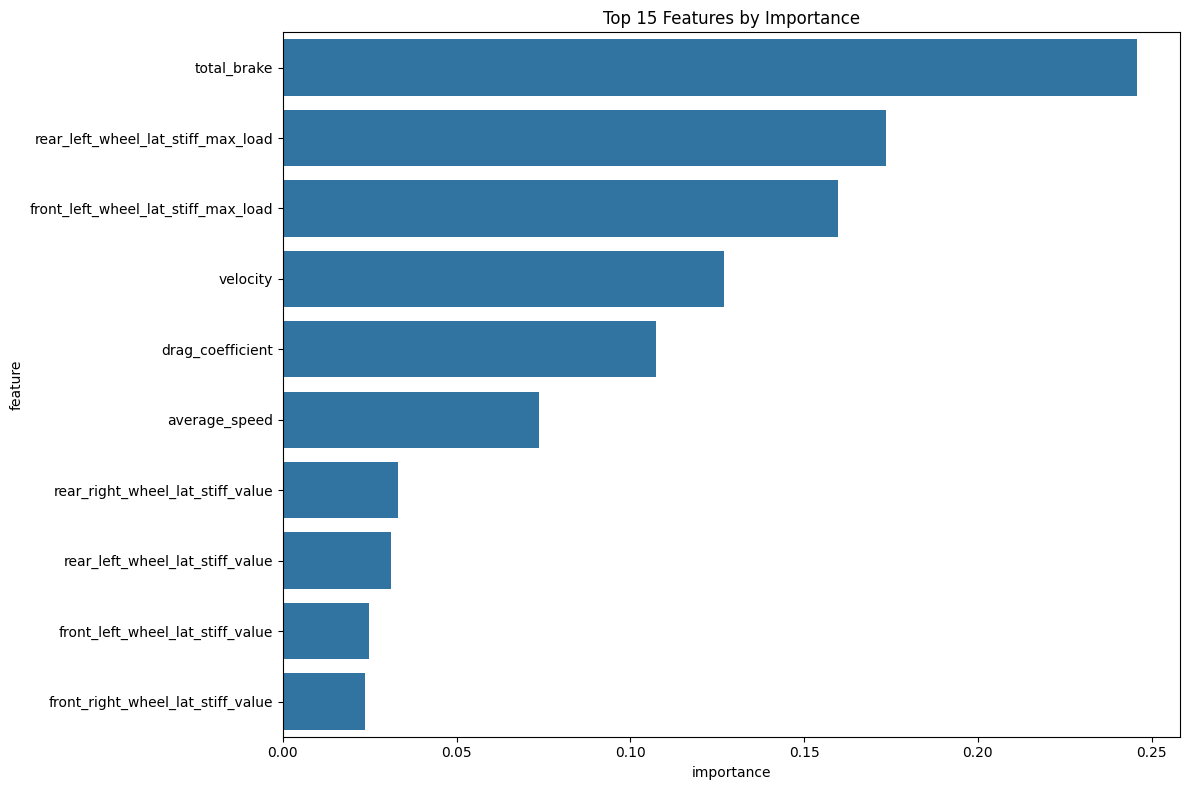

Selected features: Index(['total_brake', 'velocity', 'drag_coefficient',
       'front_left_wheel_lat_stiff_max_load',
       'rear_left_wheel_lat_stiff_max_load'],
      dtype='object')


In [ ]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame(
    {"feature": X.columns, "importance": rf_selector.feature_importances_}
).sort_values("importance", ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x="importance", y="feature", data=feature_importance.head(15))
plt.title("Top 15 Features by Importance")
plt.tight_layout()
plt.show()

# Select top features
selector = SelectFromModel(rf_selector, prefit=True, threshold="median")
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)
selected_features = X.columns[selector.get_support()]
print(f"Selected features: {selected_features}")

## Training the Classification Model

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGB.XGBClassifier(random_state=42, eval_metric="mlogloss"),
    "Naive Bayes": GaussianNB(),
}

We are searching for the best hyper parameters for each model

In [ ]:
best_models = {}

param_grids = {
    "Random Forest": {
        "n_estimators": [120, 200, 300],
        "max_depth": [4, 7, 8, 10],
        "min_samples_split": [4, 7],
    },
    "Gradient Boosting": {
        "n_estimators": [120, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [5, 7],
    },
    "XGBoost": {
        "n_estimators": [120, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [5, 7],
    },
    "Naive Bayes": {"var_smoothing": [1e-9, 1e-8, 1e-7, 1e-6]},
}

In [ ]:
for name, model in models.items():
    grid_search = GridSearchCV(
        model, param_grids[name], cv=5, scoring="accuracy", n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_selected, y_train)

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    best_models[name] = grid_search.best_estimator_

results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")

    # Convert numeric predictions back to original labels
    y_pred_original = le_target.inverse_transform(y_pred)
    y_test_original = le_target.inverse_transform(y_test)

    print(classification_report(y_test_original, y_pred_original))


for name, model in models.items():
    grid_search = GridSearchCV(
        model, param_grids[name], cv=5, scoring="accuracy", n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train_selected, y_train)

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

    best_models[name] = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Random Forest: {'max_depth': 7, 'min_samples_split': 7, 'n_estimators': 120}
Best cross-validation score: 0.9398
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation score: 0.9388
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
Best cross-validation score: 0.9402
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Naive Bayes: {'var_smoothing': 1e-09}
Best cross-validation score: 0.7089

Random Forest Results:
Accuracy: 0.9302
              precision    recall  f1-score   support

         Car       1.00      1.00      1.00      1050
  Motorcycle       0.99      0.81      0.89       600
       Truck       0.98      0.89      0.93       450
         

### Visualizing Model Performance


Random Forest Results:
Accuracy: 0.9302
              precision    recall  f1-score   support

         Car       1.00      1.00      1.00      1050
  Motorcycle       0.99      0.81      0.89       600
       Truck       0.98      0.89      0.93       450
         Van       0.73      0.98      0.83       450

    accuracy                           0.93      2550
   macro avg       0.92      0.92      0.91      2550
weighted avg       0.95      0.93      0.93      2550



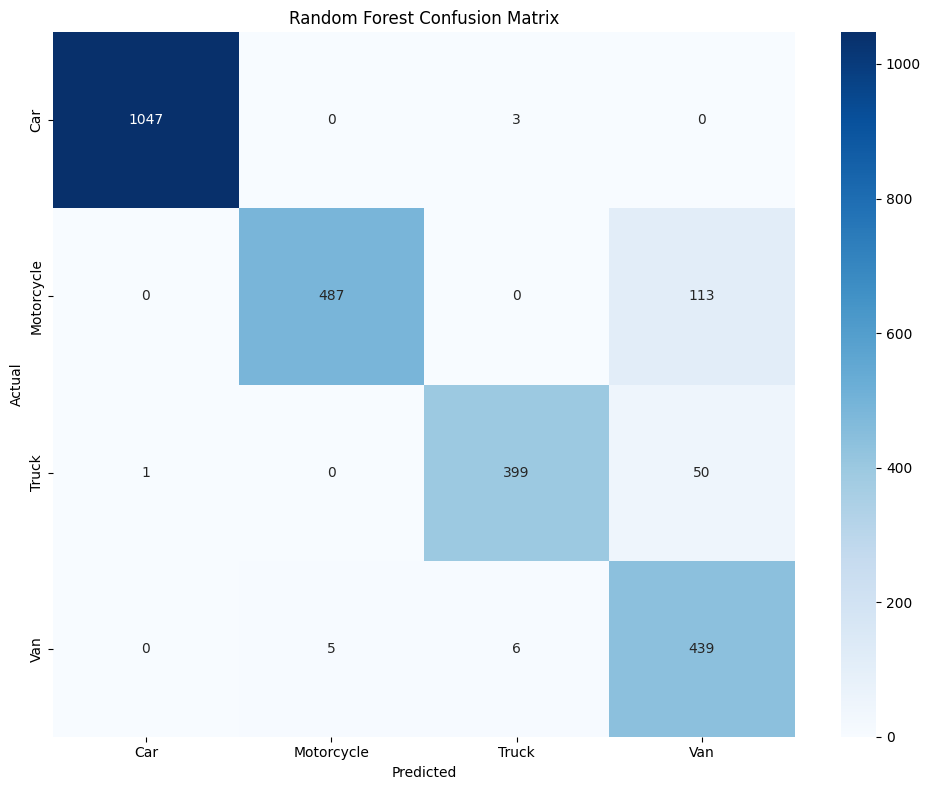


Gradient Boosting Results:
Accuracy: 0.9314
              precision    recall  f1-score   support

         Car       1.00      1.00      1.00      1050
  Motorcycle       0.99      0.81      0.89       600
       Truck       0.99      0.88      0.93       450
         Van       0.73      0.99      0.84       450

    accuracy                           0.93      2550
   macro avg       0.93      0.92      0.92      2550
weighted avg       0.95      0.93      0.93      2550



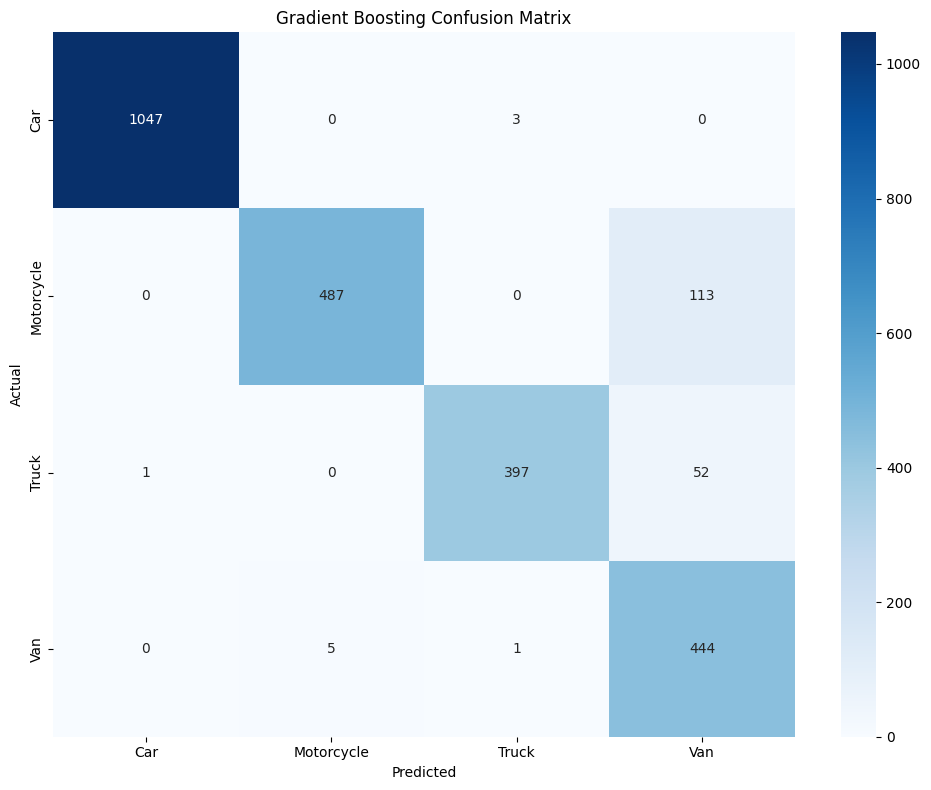


XGBoost Results:
Accuracy: 0.9302
              precision    recall  f1-score   support

         Car       1.00      1.00      1.00      1050
  Motorcycle       0.99      0.81      0.89       600
       Truck       0.97      0.89      0.93       450
         Van       0.73      0.97      0.83       450

    accuracy                           0.93      2550
   macro avg       0.92      0.92      0.91      2550
weighted avg       0.94      0.93      0.93      2550



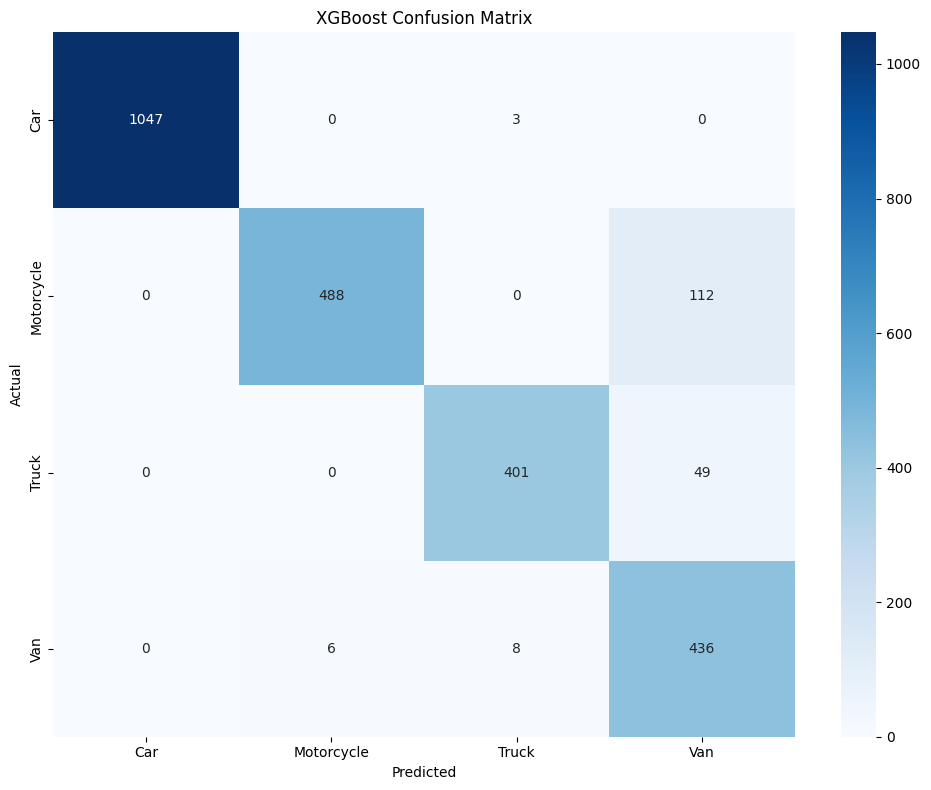


Naive Bayes Results:
Accuracy: 0.7063
              precision    recall  f1-score   support

         Car       0.86      0.98      0.92      1050
  Motorcycle       0.58      1.00      0.73       600
       Truck       0.62      0.18      0.28       450
         Van       0.50      0.20      0.29       450

    accuracy                           0.71      2550
   macro avg       0.64      0.59      0.55      2550
weighted avg       0.69      0.71      0.65      2550



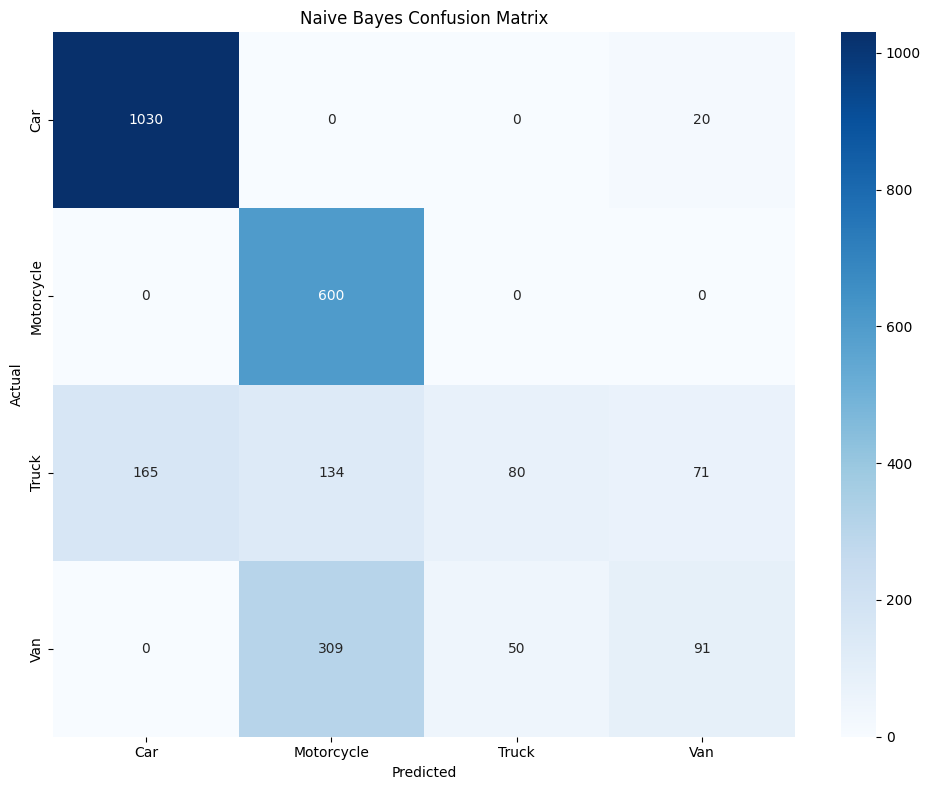

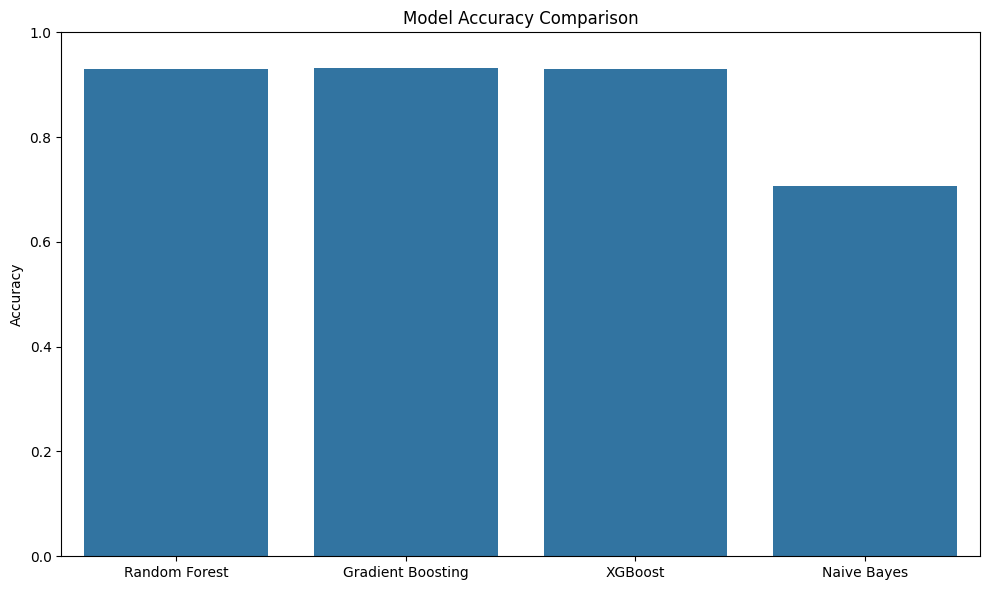

In [ ]:
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")

    y_pred_original = le_target.inverse_transform(y_pred)
    y_test_original = le_target.inverse_transform(y_test)

    print(classification_report(y_test_original, y_pred_original))

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test_original, y_pred_original)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=le_target.classes_,
        yticklabels=le_target.classes_,
    )
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylim(0, 1)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

## Clustering with Scikit-Learn

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv("./Data.csv")

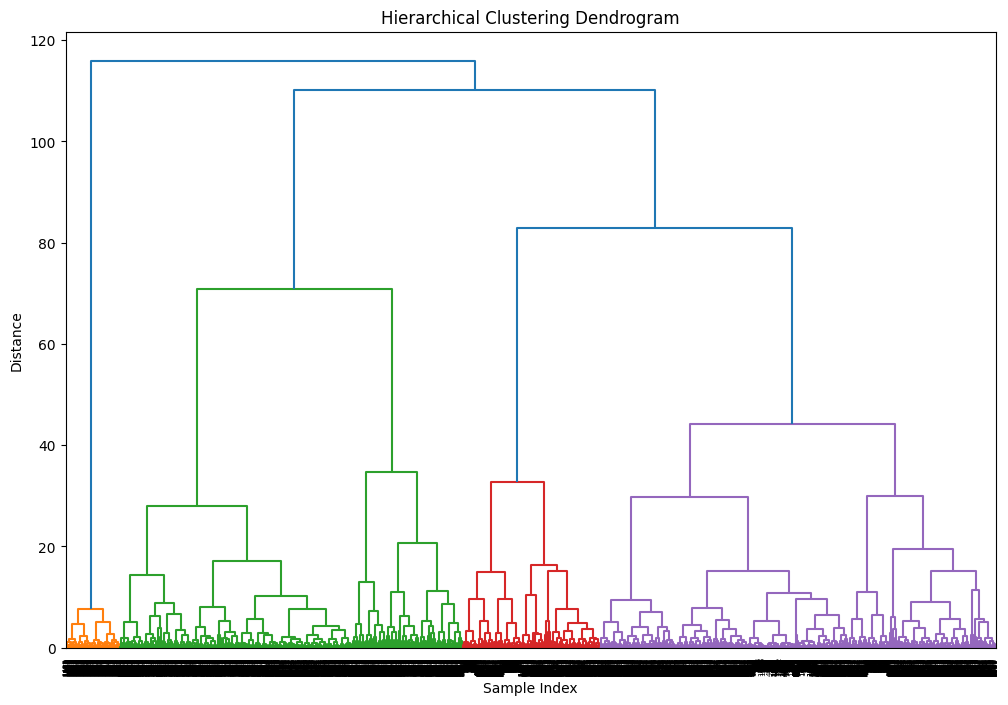

In [ ]:
features = ["average_speed", "fuel_consumption", "lap time"]
X_cluster = df[features].values

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

linkage_matrix = linkage(X_cluster_scaled, method="ward")

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

### Performing Hierarchical Clustering

In [ ]:
n_clusters = 4
clustering = AgglomerativeClustering(n_clusters=n_clusters)
cluster_labels = clustering.fit_predict(X_cluster_scaled)

# Add cluster labels to the dataframe
df["cluster"] = cluster_labels

In [ ]:
# Create cluster analysis DataFrame
cluster_analysis = pd.DataFrame(
    {
        "vehicle_type": df["vehicle_type"],
        "cluster": df["cluster"],
        "average_speed": df["average_speed"],
        "fuel_consumption": df["fuel_consumption"],
        "lap_time": df["lap time"],
    }
)

print("=== Cluster Analysis ===\n")

# 1. Vehicle type distribution per cluster
vehicle_dist = pd.crosstab(
    cluster_analysis["cluster"], cluster_analysis["vehicle_type"]
)
print("Vehicle Types per Cluster:")
print(vehicle_dist, "\n")

# 2. Cluster statistics
cluster_stats = (
    cluster_analysis.groupby("cluster")
    .agg(
        {
            "average_speed": ["mean", "std"],
            "fuel_consumption": ["mean", "std"],
            "lap_time": ["mean", "std"],
        }
    )
    .round(2)
)

# Make the column names more readable
cluster_stats.columns = [
    "Avg Speed (mean)",
    "Avg Speed (std)",
    "Fuel Cons (mean)",
    "Fuel Cons (std)",
    "Lap Time (mean)",
    "Lap Time (std)",
]

print("\nCluster Statistics:")
print(cluster_stats)

# 3. Most common vehicle type in each cluster
dominant_type = vehicle_dist.idxmax(axis=1)
print("\nDominant Vehicle Type per Cluster:")
for cluster in range(n_clusters):
    print(f"Cluster {cluster}: {dominant_type[cluster]}")

=== Cluster Analysis ===

Vehicle Types per Cluster:
vehicle_type   Car  Motorcycle  Truck   Van
cluster                                    
0                0        2000    132  1000
1              517           0    405   336
2             2983           0    463   164
3                0           0    500     0 


Cluster Statistics:
         Avg Speed (mean)  Avg Speed (std)  Fuel Cons (mean)  Fuel Cons (std)  \
cluster                                                                         
0                   15.31             0.55              0.00              0.0   
1                   14.49             0.36              0.01              0.0   
2                   15.54             0.40              0.01              0.0   
3                   15.56             0.16              0.03              0.0   

         Lap Time (mean)  Lap Time (std)  
cluster                                   
0                  45.90            1.34  
1                  43.05            1.11  
2

### Visualizing Clustering Results

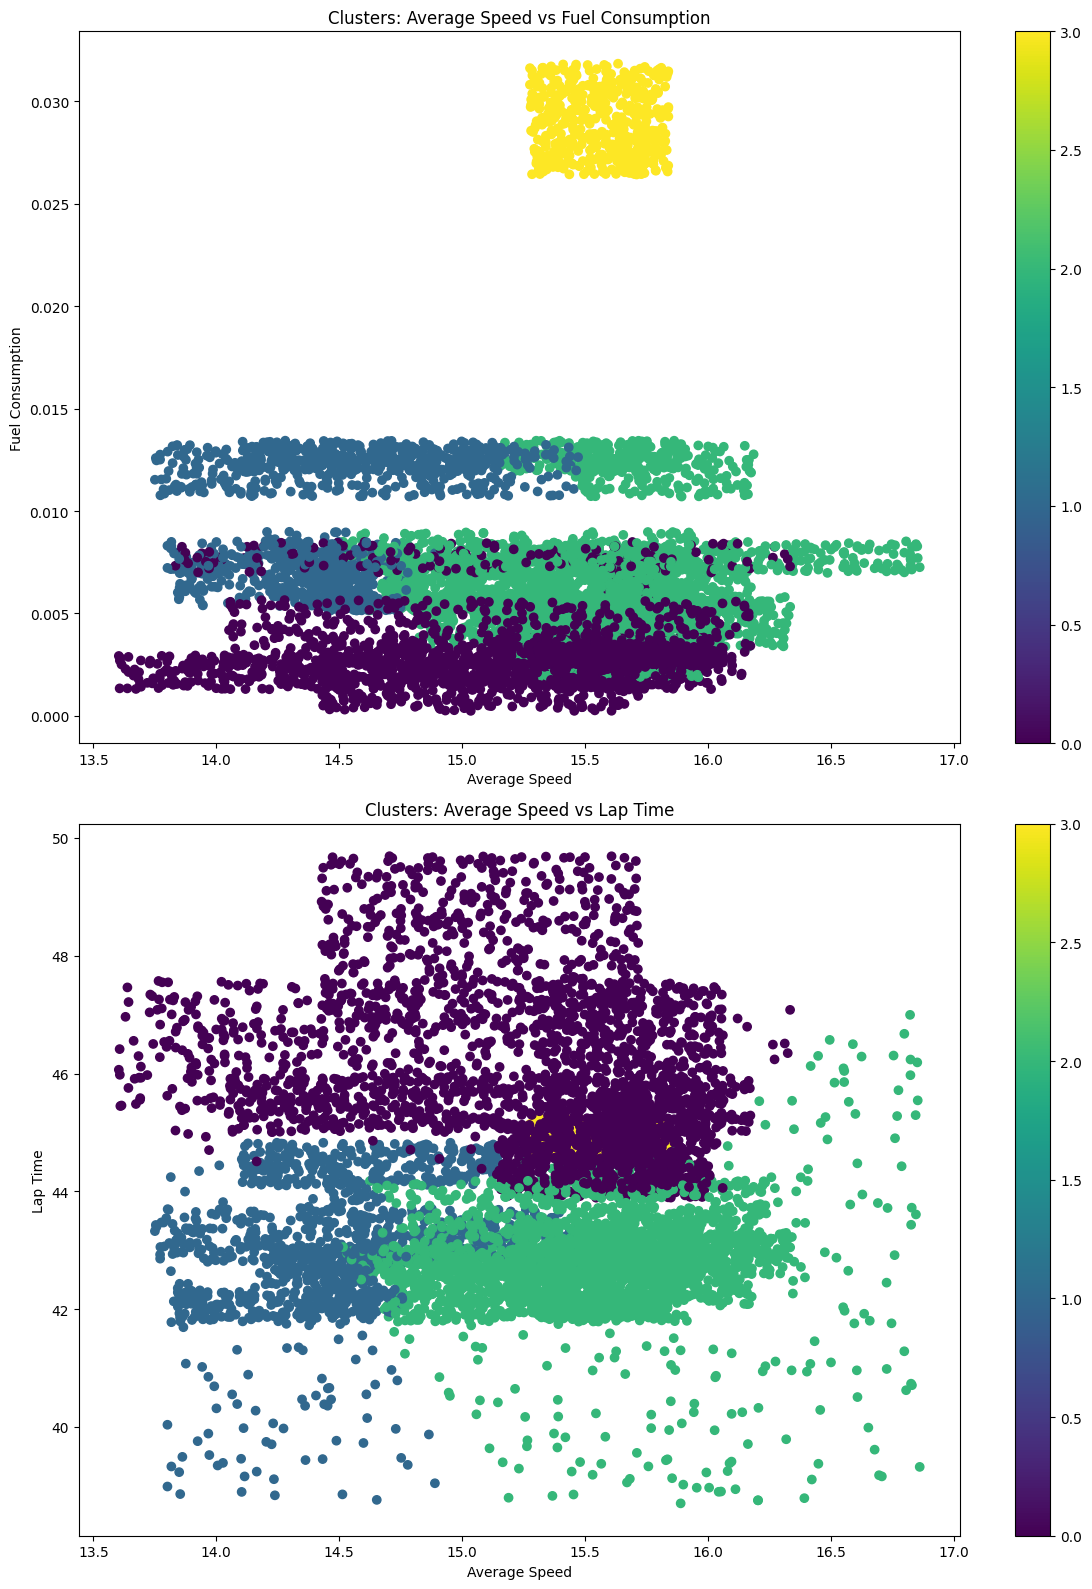

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# First plot: average_speed vs fuel_consumption
scatter1 = axes[0].scatter(
    df["average_speed"], df["fuel_consumption"], c=df["cluster"], cmap="viridis"
)
axes[0].set_xlabel("Average Speed")
axes[0].set_ylabel("Fuel Consumption")
axes[0].set_title("Clusters: Average Speed vs Fuel Consumption")
plt.colorbar(scatter1, ax=axes[0])

# Second plot: average_speed vs lap_time
scatter2 = axes[1].scatter(
    df["average_speed"], df["lap time"], c=df["cluster"], cmap="viridis"
)
axes[1].set_xlabel("Average Speed")
axes[1].set_ylabel("Lap Time")
axes[1].set_title("Clusters: Average Speed vs Lap Time")
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
# Print cluster statistics
print("\nCluster Statistics:")
for cluster in range(n_clusters):
    cluster_data = df[df["cluster"] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"Size: {len(cluster_data)}")
    print("\nMean values:")
    print(cluster_data[features].mean())
    print("\nVehicle types in cluster:")
    print(cluster_data["vehicle_type"].value_counts())


Cluster Statistics:

Cluster 0:
Size: 3132

Mean values:
average_speed       15.312440
fuel_consumption     0.003400
lap time            45.901222
dtype: float64

Vehicle types in cluster:
vehicle_type
Motorcycle    2000
Van           1000
Truck          132
Name: count, dtype: int64

Cluster 1:
Size: 1258

Mean values:
average_speed       14.485885
fuel_consumption     0.009567
lap time            43.047291
dtype: float64

Vehicle types in cluster:
vehicle_type
Car      517
Truck    405
Van      336
Name: count, dtype: int64

Cluster 2:
Size: 3610

Mean values:
average_speed       15.536944
fuel_consumption     0.006351
lap time            42.780647
dtype: float64

Vehicle types in cluster:
vehicle_type
Car      2983
Truck     463
Van       164
Name: count, dtype: int64

Cluster 3:
Size: 500

Mean values:
average_speed       15.560235
fuel_consumption     0.028973
lap time            44.957927
dtype: float64

Vehicle types in cluster:
vehicle_type
Truck    500
Name: count, dtype: int

## PySpark Analysis of Vehicle Data

### Setting Up and Importing Dependencies

In [ ]:
!pip install pyspark


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
!apt-get update
!apt-get install -y openjdk-11-jdk

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


### Checking PySpark Environment

**Check java version to make sure the installation went smoothly** 

In [ ]:
!java -version

java version "20.0.1" 2023-04-18
Java(TM) SE Runtime Environment (build 20.0.1+9-29)
Java HotSpot(TM) 64-Bit Server VM (build 20.0.1+9-29, mixed mode, sharing)


In [ ]:
import pyspark
from pyspark.sql import SparkSession

# Initialize a Spark session
# spark = SparkSession.builder.appName("MLSpark").getOrCreate()

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("MLSpark")
    .config("spark.driver.memory", "8g")
    .config("spark.executor.memory", "4g")
    .getOrCreate()
)
print(spark)
spark

In [ ]:
try:
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import *
    from pyspark.ml import Pipeline
    from pyspark.ml.feature import (
        VectorAssembler,
        StringIndexer,
        OneHotEncoder,
        StandardScaler,
        Bucketizer,
    )
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.classification import (
        DecisionTreeClassifier,
        NaiveBayes,
        RandomForestClassifier,
    )
    from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
    from pyspark.ml.evaluation import (
        MulticlassClassificationEvaluator,
        RegressionEvaluator,
        BinaryClassificationEvaluator,
    )
    from pyspark.ml.classification import (
        DecisionTreeClassifier,
        NaiveBayes,
        RandomForestClassifier,
    )
    from pyspark.ml.classification import GBTClassifier

    import matplotlib.pyplot as plt
    import pandas as pd
    import seaborn as sns
    import time

    print("All PySpark libraries imported successfully!")

except ModuleNotFoundError as e:
    print(f" Import Error: {e}")

All PySpark libraries imported successfully!


#### Loading Data into a PySpark DataFrame

In [ ]:
spark.conf.set("spark.sql.debug.maxToStringFields", 100)
file_path = "./Data.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.printSchema()

root
 |-- average_speed: double (nullable = true)
 |-- fuel_consumption: double (nullable = true)
 |-- total_steering: double (nullable = true)
 |-- total_throttle: double (nullable = true)
 |-- total_brake: double (nullable = true)
 |-- velocity: double (nullable = true)
 |-- lap time: double (nullable = true)
 |-- vehicle_name: string (nullable = true)
 |-- lap: integer (nullable = true)
 |-- vehicle_type: string (nullable = true)
 |-- mass: double (nullable = true)
 |-- drag_coefficient: double (nullable = true)
 |-- center_of_mass_x: double (nullable = true)
 |-- center_of_mass_z: double (nullable = true)
 |-- max_rpm: double (nullable = true)
 |-- clutch_strength: double (nullable = true)
 |-- gear_switch_time: double (nullable = true)
 |-- front_left_wheel_max_steer_angle: double (nullable = true)
 |-- front_left_wheel_radius: double (nullable = true)
 |-- front_left_wheel_max_brake_torque: double (nullable = true)
 |-- front_left_wheel_lat_stiff_max_load: double (nullable = true

#### Displaying a Sample of the Data

In [ ]:
from pyspark.sql import functions as F

df = df.withColumn("fuel_consumption", F.col("fuel_consumption") * 100)
df_pandas = df.limit(5).toPandas()
display(df_pandas.style.set_properties(**{"text-align": "left"}))

,average_speed,fuel_consumption,total_steering,total_throttle,total_brake,velocity,lap time,vehicle_name,lap,vehicle_type,mass,drag_coefficient,center_of_mass_x,center_of_mass_z,max_rpm,clutch_strength,gear_switch_time,front_left_wheel_max_steer_angle,front_left_wheel_radius,front_left_wheel_max_brake_torque,front_left_wheel_lat_stiff_max_load,front_left_wheel_lat_stiff_value,front_left_wheel_long_stiff_value,front_left_wheel_position_x,front_left_wheel_position_y,front_left_wheel_position_z,front_right_wheel_max_steer_angle,front_right_wheel_radius,front_right_wheel_max_brake_torque,front_right_wheel_lat_stiff_max_load,front_right_wheel_lat_stiff_value,front_right_wheel_long_stiff_value,front_right_wheel_position_x,front_right_wheel_position_y,front_right_wheel_position_z,rear_left_wheel_radius,rear_left_wheel_max_brake_torque,rear_left_wheel_max_handbrake_torque,rear_left_wheel_lat_stiff_max_load,rear_left_wheel_lat_stiff_value,rear_left_wheel_long_stiff_value,rear_left_wheel_position_x,rear_left_wheel_position_y,rear_left_wheel_position_z,rear_right_wheel_radius,rear_right_wheel_max_brake_torque,rear_right_wheel_max_handbrake_torque,rear_right_wheel_lat_stiff_max_load,rear_right_wheel_lat_stiff_value,rear_right_wheel_long_stiff_value,rear_right_wheel_position_x,rear_right_wheel_position_y,rear_right_wheel_position_z
0,15.670213,0.488613,168.013220,41.177921,3.345929,4.450584,42.023197,vehicle.audi.tt,1,Car,1265.000000,0.250000,0.500000,-0.250000,4700.000000,10.000000,0.100000,69.999992,34.000000,700.000000,3.000000,20.000000,3000.000000,9982.957031,4338.941895,87.377563,69.999992,34.000000,700.000000,3.000000,20.000000,3000.000000,9831.060547,4337.905762,87.377563,34.000000,700.000000,1400.000000,3.000000,20.000000,3000.000000,9978.859375,4074.701416,87.377563,34.000000,700.000000,1400.000000,3.000000,20.000000,3000.000000,9838.762695,4073.746094,87.377563
1,15.601593,0.467878,170.399465,37.822685,6.624914,4.622826,42.000449,vehicle.audi.tt,2,Car,1265.000000,0.250000,0.500000,-0.250000,4700.000000,10.000000,0.100000,69.999992,34.000000,700.000000,3.000000,20.000000,3000.000000,9982.957031,4338.941895,87.377563,69.999992,34.000000,700.000000,3.000000,20.000000,3000.000000,9831.060547,4337.905762,87.377563,34.000000,700.000000,1400.000000,3.000000,20.000000,3000.000000,9978.859375,4074.701416,87.377563,34.000000,700.000000,1400.000000,3.000000,20.000000,3000.000000,9838.762695,4073.746094,87.377563
2,15.485363,0.489195,173.073007,37.987570,3.902746,3.564281,42.057393,vehicle.audi.tt,3,Car,1265.000000,0.250000,0.500000,-0.250000,4700.000000,10.000000,0.100000,69.999992,34.000000,700.000000,3.000000,20.000000,3000.000000,9982.957031,4338.941895,87.377563,69.999992,34.000000,700.000000,3.000000,20.000000,3000.000000,9831.060547,4337.905762,87.377563,34.000000,700.000000,1400.000000,3.000000,20.000000,3000.000000,9978.859375,4074.701416,87.377563,34.000000,700.000000,1400.000000,3.000000,20.000000,3000.000000,9838.762695,4073.746094,87.377563
3,15.789362,0.467051,169.156264,38.547860,7.682187,4.315097,41.935543,vehicle.audi.tt,4,Car,1265.000000,0.250000,0.500000,-0.250000,4700.000000,10.000000,0.100000,69.999992,34.000000,700.000000,3.000000,20.000000,3000.000000,9982.957031,4338.941895,87.377563,69.999992,34.000000,700.000000,3.000000,20.000000,3000.000000,9831.060547,4337.905762,87.377563,34.000000,700.000000,1400.000000,3.000000,20.000000,3000.000000,9978.859375,4074.701416,87.377563,34.000000,700.000000,1400.000000,3.000000,20.000000,3000.000000,9838.762695,4073.746094,87.377563
4,15.792036,0.482587,170.409213,37.230459,3.392884,3.572567,41.955492,vehicle.audi.tt,5,Car,1265.000000,0.250000,0.500000,-0.250000,4700.000000,10.000000,0.100000,69.999992,34.000000,700.000000,3.000000,20.000000,3000.000000,9982.957031,4338.941895,87.377563,69.999992,34.000000,700.000000,3.000000,20.000000,3000.000000,9831.060547,4337.905762,87.377563,34.000000,700.000000,1400.000000,3.000000,20.000000,3000.000000,9978.859375,4074.701416,87.377563,34

In [ ]:
df.describe().show()

+-------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------+------------------+-------------------+-------------------+-------------------+-----------------+------------------+-------------------+--------------------------------+-----------------------+---------------------------------+-----------------------------------+--------------------------------+---------------------------------+---------------------------+---------------------------+---------------------------+---------------------------------+------------------------+----------------------------------+------------------------------------+---------------------------------+----------------------------------+----------------------------+----------------------------+----------------------------+----------------------+--------------------------------+------------------------------------+--------------

In [ ]:
df = df.na.drop()
df.head()

Row(average_speed=15.67021296596129, fuel_consumption=0.48861327727572995, total_steering=168.0132198046866, total_throttle=41.17792122138479, total_brake=3.345928646031358, velocity=4.450584397614042, lap time=42.02319717451219, vehicle_name='vehicle.audi.tt', lap=1, vehicle_type='Car', mass=1265.0, drag_coefficient=0.25, center_of_mass_x=0.5, center_of_mass_z=-0.25, max_rpm=4700.0, clutch_strength=10.0, gear_switch_time=0.1000000014901161, front_left_wheel_max_steer_angle=69.99999237060547, front_left_wheel_radius=34.0, front_left_wheel_max_brake_torque=700.0, front_left_wheel_lat_stiff_max_load=3.0, front_left_wheel_lat_stiff_value=20.0, front_left_wheel_long_stiff_value=3000.0, front_left_wheel_position_x=9982.95703125, front_left_wheel_position_y=4338.94189453125, front_left_wheel_position_z=87.3775634765625, front_right_wheel_max_steer_angle=69.99999237060547, front_right_wheel_radius=34.0, front_right_wheel_max_brake_torque=700.0, front_right_wheel_lat_stiff_max_load=3.0, front_

In [ ]:
df.select(["vehicle_type", "vehicle_name", "fuel_consumption", "average_speed"]).show(6)

print(f"Number of records: {df.count()}")
print(f"Number of features: {len(df.columns)}")

+------------+---------------+-------------------+-----------------+
|vehicle_type|   vehicle_name|   fuel_consumption|    average_speed|
+------------+---------------+-------------------+-----------------+
|         Car|vehicle.audi.tt|0.48861327727572995|15.67021296596129|
|         Car|vehicle.audi.tt|0.46787798591469004| 15.6015933208139|
|         Car|vehicle.audi.tt|   0.48919497114551|15.48536332606623|
|         Car|vehicle.audi.tt|0.46705115052031004|15.78936192330436|
|         Car|vehicle.audi.tt|    0.4825874171538|15.79203625849889|
|         Car|vehicle.audi.tt|0.45358594301676997|15.79285541572513|
+------------+---------------+-------------------+-----------------+
only showing top 6 rows

Number of records: 8500
Number of features: 53


## Building and Evaluating Model

## Clustering Analysis

### Converting Categorical Labels to Numeric

`oneHotEncoder` move all the cateogrical column such as vehicle type appear as columns, and turning one the new column for each relevant row.
`assembler.transform(df)` applies this transformation, adding a new column features to our dataset.
`VectorAssembler` assembl a vector of all the features

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Define StringIndexer for categorical features
vehicle_indexer = StringIndexer(
    inputCol="vehicle_type", outputCol="vehicle_type_index", handleInvalid="keep"
)
track_indexer = StringIndexer(
    inputCol="track_type", outputCol="track_type_index", handleInvalid="keep"
)
vehicle_name_indexer = StringIndexer(
    inputCol="vehicle_name", outputCol="vehicle_name_index", handleInvalid="keep"
)

# Define OneHotEncoder
encoder = OneHotEncoder(
    inputCols=["vehicle_type_index", "track_type_index", "vehicle_name_index"],
    outputCols=["vehicle_type_onehot", "track_type_onehot", "vehicle_name_onehot"],
    dropLast=False,
)

In [ ]:
features = ["average_speed", "fuel_consumption", "lap time"]
assembler_numeric = VectorAssembler(inputCols=features, outputCol="features")

scaler = StandardScaler(inputCol="features_numeric", outputCol="features_scaled")

input_cols = [
    "vehicle_type_onehot",
    "track_type_onehot",
    "vehicle_name_onehot",
    "avg_speed",
    "fuel_consumption",
    "lap time",
]

assembler_full = VectorAssembler(inputCols=input_cols, outputCol="features")

df_cluster = assembler_numeric.transform(df)

df_cluster.select("features").show(5, truncate=False)

+---------------------------------------------------------+
|features                                                 |
+---------------------------------------------------------+
|[15.67021296596129,0.48861327727572995,42.02319717451219]|
|[15.6015933208139,0.46787798591469004,42.00044864157726] |
|[15.48536332606623,0.48919497114551,42.05739321912051]   |
|[15.78936192330436,0.46705115052031004,41.93554325469784]|
|[15.79203625849889,0.4825874171538,41.95549203455207]    |
+---------------------------------------------------------+
only showing top 5 rows



### Applying Bisecting K-Means Clustering

In [ ]:
from pyspark.ml.clustering import BisectingKMeans

# Initialize Bisecting K-means
bkm = BisectingKMeans(k=4, featuresCol="features")

model = bkm.fit(df_cluster)

clustered_data = model.transform(df_cluster)

- `k=4` means we want to create 3 clusters.
- `featuresCol="features"` tells PySpark that we are using the features column created earlier.
- `clustered_data = model.transform(df_cluster)` assigns each data point to a cluster.

### Examining Cluster Assignments

In [ ]:
clustered_data.select(
    "features", "vehicle_name", "vehicle_type", "lap time", "prediction"
).show(5)

+--------------------+---------------+------------+-----------------+----------+
|            features|   vehicle_name|vehicle_type|         lap time|prediction|
+--------------------+---------------+------------+-----------------+----------+
|[15.6702129659612...|vehicle.audi.tt|         Car|42.02319717451219|         0|
|[15.6015933208139...|vehicle.audi.tt|         Car|42.00044864157726|         0|
|[15.4853633260662...|vehicle.audi.tt|         Car|42.05739321912051|         0|
|[15.7893619233043...|vehicle.audi.tt|         Car|41.93554325469784|         0|
|[15.7920362584988...|vehicle.audi.tt|         Car|41.95549203455207|         0|
+--------------------+---------------+------------+-----------------+----------+
only showing top 5 rows



### Data Sample for Cluster 2

In [ ]:
clustered_data.select(
    "features", "vehicle_name", "vehicle_type", "prediction", "lap time"
).where(clustered_data.prediction == 2).show(5)

+--------------------+--------------------+------------+----------+-----------------+
|            features|        vehicle_name|vehicle_type|prediction|         lap time|
+--------------------+--------------------+------------+----------+-----------------+
|[14.4339359912678...|vehicle.carlamoto...|       Truck|         2|44.59413662635953|
|[15.0338086567840...|vehicle.carlamoto...|       Truck|         2| 44.6575683990185|
|[14.7485897299238...|vehicle.carlamoto...|       Truck|         2|44.67753564038888|
|[15.4913585316313...|vehicle.carlamoto...|       Truck|         2| 44.4438463229247|
|[15.7101170893452...|vehicle.carlamoto...|       Truck|         2|44.41902404508023|
+--------------------+--------------------+------------+----------+-----------------+
only showing top 5 rows



### Visualizing Clustering Results

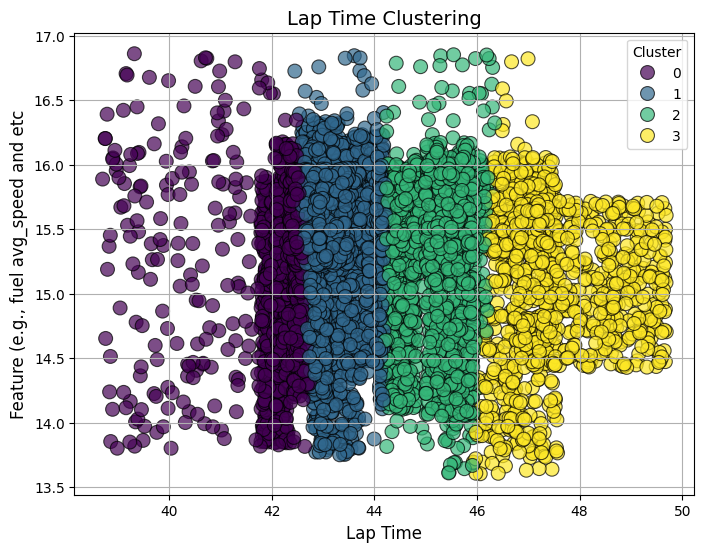

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert clustered PySpark DataFrame to Pandas
clustered_data_pd = clustered_data.select(
    "features", "lap time", "prediction"
).toPandas()


plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=clustered_data_pd["lap time"],
    y=clustered_data_pd["features"].apply(lambda x: x[0]),
    hue=clustered_data_pd["prediction"],
    palette="viridis",
    s=100,
    alpha=0.7,
    edgecolor="black",
)

plt.title("Lap Time Clustering", fontsize=14)
plt.xlabel("Lap Time", fontsize=12)
plt.ylabel("Feature (e.g., fuel avg_speed and etc", fontsize=12)
plt.legend(title="Cluster", loc="upper right")
plt.grid(True)
plt.show()